## Index of Notebook
1. Data Understanding
2. Exploratory Data Analysis
3. Data Preparation
4. Building Linear Regression Model
5. Residual Analysis
6. [Evaluation on Test Data](#another_cell)
7. Equation of Best Fit Line

In [405]:
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

## 1. Data Understanding

In [406]:
data=pd.read_csv("day.csv")
data.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


In [407]:
#Dropping columns :
#instant-not needed as index is not useful
#dteday - already days,year and month is covered in other features
#casual,registered - since casual and registered cannot predict total count,they are just a biforcation of target variable
data.drop(["instant","dteday","casual","registered"],axis=1,inplace=True)

In [408]:
data.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,985
1,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,801
2,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,1349
3,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,1562
4,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,1600


## 2. Exploratory Data Analysis

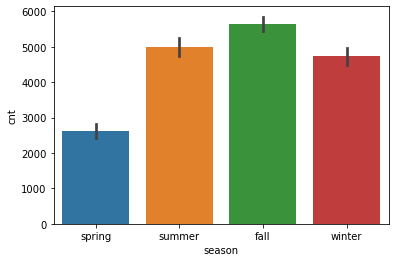

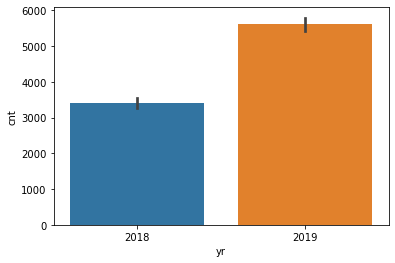

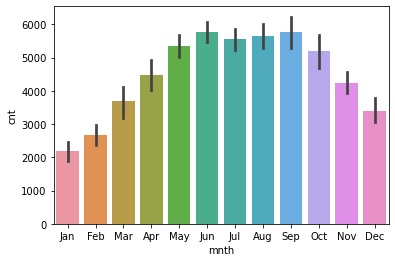

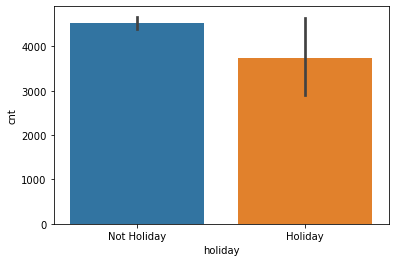

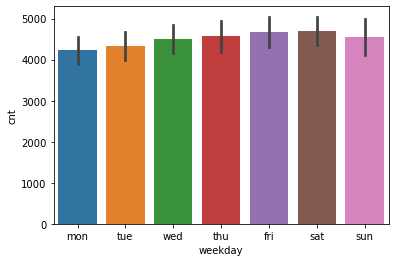

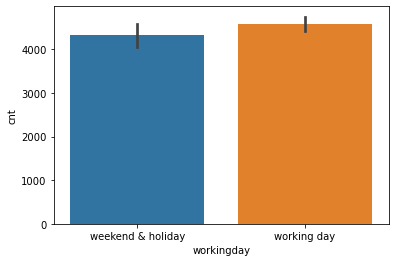

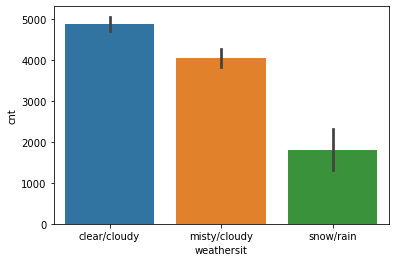

In [409]:
#Understanding categorical data with target variable
cat_features=["season","yr","mnth","holiday","weekday","workingday","weathersit"]
#Dictionary for x axis labels
cat_features_dict={"season":["spring","summer","fall","winter"],"yr":["2018","2019"],"mnth":["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"],"holiday":["Not Holiday","Holiday"]
,"weekday":["mon","tue","wed","thu","fri","sat","sun"],"workingday":["weekend & holiday","working day"],"weathersit":["clear/cloudy","misty/cloudy","snow/rain"]}
for feature in cat_features:
    ax=sns.barplot(data=data,y='cnt',x=feature)
    ax.set_xticklabels(cat_features_dict[feature])
    plt.show()

### Insights
-There are low customers sharing bikes during spring season<br>
-There are higher customers(nearly doubled) sharing bikes in 2019 as compared to 2018<br>
-People share bikes lesser in holidays as compared to non-holidays<br>
-People have taken more bikes in clear and cloudy weather as compared to other weather conditions<br>
-There is no significant effect of weekday or working day on the count of customers sharing the bikes<br><br>
`This helps us understand what might the important features to consider for linear regression based on the data`

In [410]:
#Describing numeric features in your dataset
numeric_features=["temp","atemp","hum","windspeed","cnt"]

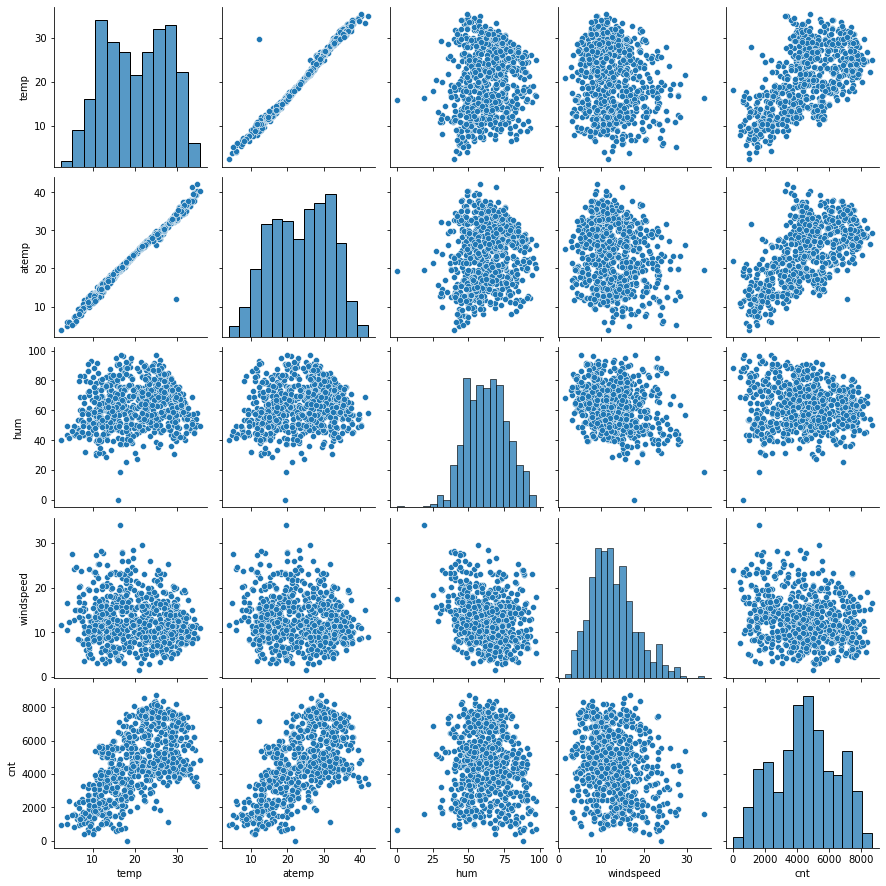

In [411]:
#Understanding the numeric data
#Checking pair plots for numeric features
sns.pairplot(data[numeric_features])
plt.show()

Inference - Atemp and temp are highly correlated with target variable, but they are highly correlated within themselves too

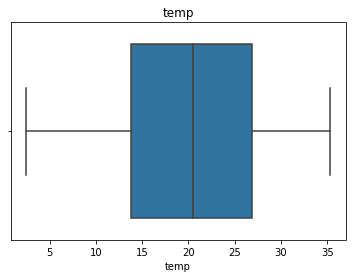

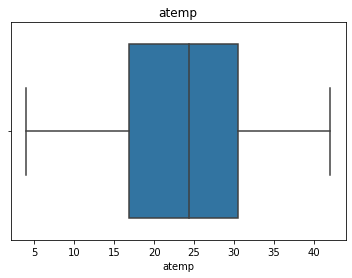

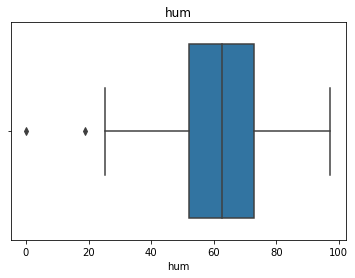

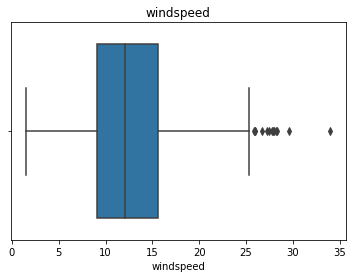

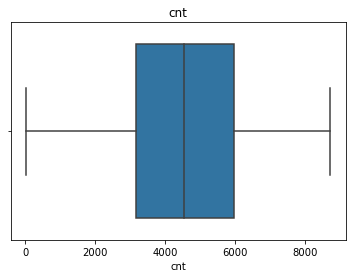

In [412]:
#Box Plot
for feature in numeric_features:
    sns.boxplot(data[feature])
    plt.title(feature)
    plt.show()

### Insights
- There are some outliers in input variables(humidity and windspeed)<br>
- There are no outliers in the target variable(cnt)<br>

`However we cannot remove outliers based on only input data, we have to check its effect on target variable and remove the outliers`

In [418]:
#May not be visible in some notebooks if plotly is not installed
try:
    import plotly.express as px
    for feature in numeric_features:
        if feature!="cnt":
            fig = px.scatter(data, x=feature, y="cnt")
            fig.show()
except:
    print("Plotly is not installed in your system")

Outlier Detection - From the scatter plots, some points were out of trend, for fitting Linear regression model, its important to clean the data and remove extreme points(outliers).

In [414]:
#List of tuplies (feature value, target value)
outlier_temp=[(25.99043,1842),(27.88,1115),(18.04,22),(35.328347,4840)]
outlier_atemp=[(12.12,7148),(21.97,22),(31.7778,1115),(42.0448,3387),(41.31855,3784)]
outlier_hum=[(0,623),(18.7917,1635)]
outlier_windspeed=[(1.5002439,4985),(34.000021,1635),(29.584721,5382)]
outlier_dict={"temp":outlier_temp,"atemp":outlier_atemp,"hum":outlier_hum,"windspeed":outlier_windspeed}

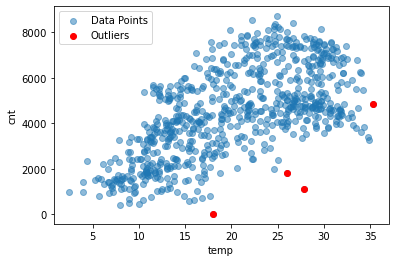

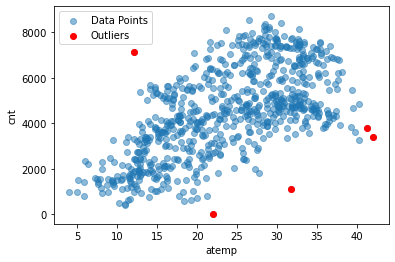

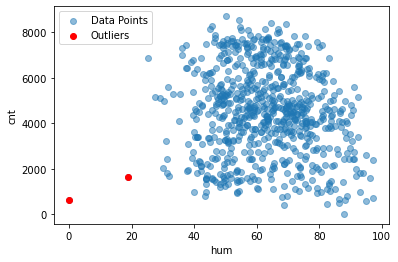

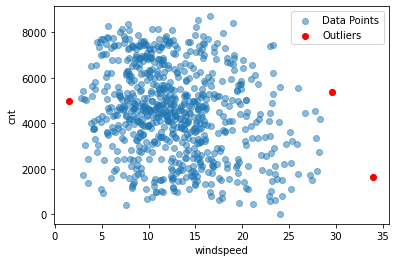

In [417]:
#Highlighting outliers - Red points
for feature in numeric_features:
    if feature!="cnt":
        dp=plt.scatter(data[feature],data["cnt"],alpha=0.5,label="Data Points")
        plt.xlabel(feature)
        plt.ylabel("cnt")
        out_pnts=outlier_dict[feature]
        i=0
        for xy in out_pnts:
            if i==0:
                plt.scatter(xy[0],xy[1],color="red",label="Outliers")
            else:
                plt.scatter(xy[0],xy[1],color="red")
            i+=1
        plt.legend()
        plt.show()


`All the numeric features show linearity with the target variable, it is good to use multi linear regression for this problem`

### 3. Data Preparation

In [419]:
#We can find some outliers in windspeed and humidity,capping those variables to maximum bounds
def remove_outliers(df,feature,odict):
    tup=odict[feature]
    for t in tup:        
        df=df[~((df[feature] == t[0]) & (df["cnt"] == t[1]))]
    # print(f"Outliers removed in {feature}")
    return df
init_len=len(data)

data=remove_outliers(data,"temp",outlier_dict)
data=remove_outliers(data,"atemp",outlier_dict)
data=remove_outliers(data,"hum",outlier_dict)
data=remove_outliers(data,"windspeed",outlier_dict)
#Total outliers removed
fin_len=len(data)
rem=init_len-fin_len
print(f"Totally {rem} outliers removed from data")

Totally 10 outliers removed from data


In [338]:
#Dummy encoding weathersit variable
#Combinations : 
#10 - Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
#01 - Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
#00 - Clear, Few clouds, Partly cloudy, Partly cloudy
# Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog -- Absent in data
weather_status=pd.get_dummies(data["weathersit"],drop_first=True)
weather_status.rename(columns={2:"misty",3:"light rain/snow"},inplace=True)
data=pd.concat([data,weather_status],axis=1)
data.drop("weathersit",axis=1,inplace=True)

In [339]:
#Dummy encoding seasons variable
#000-spring
#100-summer
#010-fall
#001-winter
seasons=pd.get_dummies(data["season"],drop_first=True)
seasons.rename(columns={2:"summer",3:"fall",4:"winter"},inplace=True)
data=pd.concat([data,seasons],axis=1)
data.drop("season",axis=1,inplace=True)

In [340]:
#Dataframe after encoding
data.head()

,yr,mnth,holiday,weekday,workingday,temp,atemp,hum,windspeed,cnt,misty,light rain/snow,summer,fall,winter
0,0,1,0,6,0,14.110847,18.18125,80.5833,10.749882,985,1,0,0,0,0
1,0,1,0,0,0,14.902598,17.68695,69.6087,16.652113,801,1,0,0,0,0
2,0,1,0,1,1,8.050924,9.47025,43.7273,16.636703,1349,0,0,0,0,0
3,0,1,0,2,1,8.200000,10.60610,59.0435,10.739832,1562,0,0,0,0,0
4,0,1,0,3,1,9.305237,11.46350,43.6957,12.522300,1600,0,0,0,0,0


In [341]:
from sklearn.model_selection import train_test_split

# Splitting into train and test dataframes
df_train, df_test = train_test_split(data, train_size = 0.7, test_size = 0.3, random_state = 0)

In [342]:
df_train[numeric_features].describe()

,temp,atemp,hum,windspeed,cnt
count,503.000000,503.000000,503.000000,503.000000,503.000000
mean,20.229678,23.643633,62.527768,12.714344,4526.880716
std,7.544800,8.183477,14.181348,5.166420,1879.797920
min,3.957390,4.941955,25.416700,2.834381,431.000000
25%,13.940000,16.918125,50.833350,8.895791,3241.000000
50%,20.055847,23.925600,62.916700,12.291418,4548.000000
75%,26.957500,30.587700,72.895800,15.616829,5893.500000
max,34.815847,40.214350,97.250000,28.292425,8555.000000


In [343]:
df_test[numeric_features].describe()

,temp,atemp,hum,windspeed,cnt
count,216.000000,216.000000,216.000000,216.000000,216.000000
mean,20.327282,23.753409,63.718296,12.671080,4517.666667
std,7.361700,7.950863,13.495282,4.818376,2038.166858
min,2.424346,3.953480,31.416700,3.042356,683.000000
25%,13.615413,16.287500,53.708350,9.343904,2882.000000
50%,20.944173,24.888975,62.233700,11.792000,4562.500000
75%,26.615847,30.193375,73.395825,15.437772,6185.250000
max,34.030000,39.741450,96.250000,27.292182,8714.000000


#### Insights : It can be seen that df_train and df_test don't have significant differences in the mean,median and quantile values of features and predictors, hence its `randomly split` and `not biased`

<Figure size 1080x720 with 0 Axes>

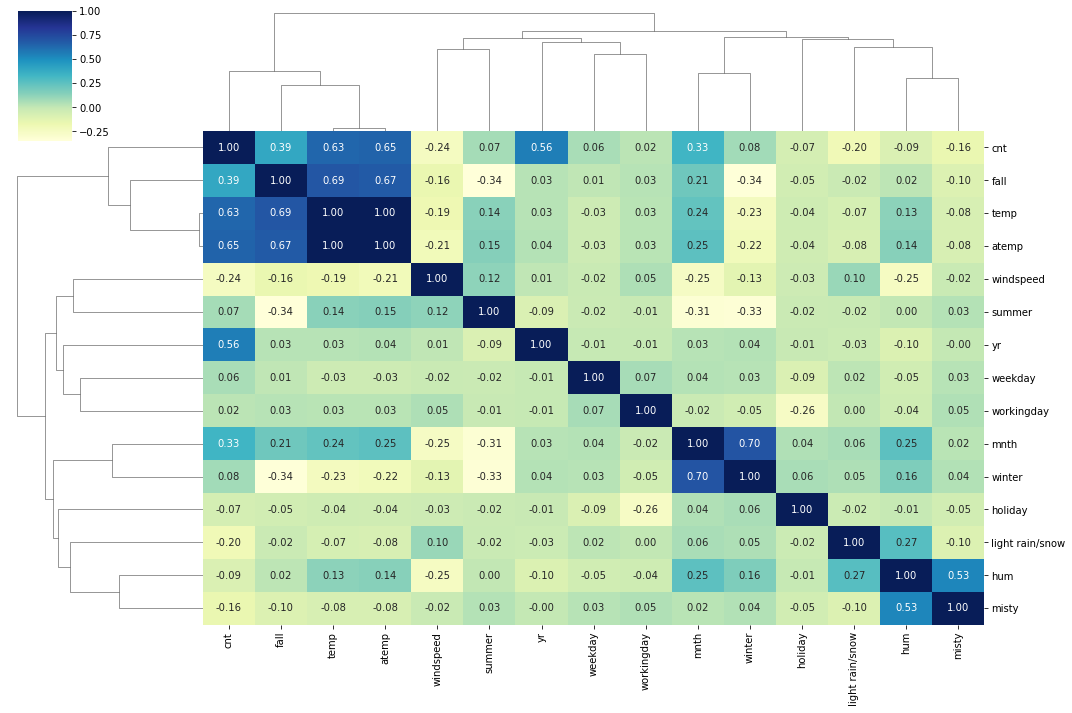

In [344]:
#Correlation Map
plt.figure(figsize=(15,10))
# sns.heatmap(df_train.corr(),annot=True,cmap="YlGnBu",fmt=".2f")
sns.clustermap(df_train.corr(), figsize=(15, 10),annot=True,cmap="YlGnBu",fmt=".2f")

### Insights
-Target variable cnt is highly correlated with atemp,yr,fall season, its also correlating with mnth,windspeed & weather(light rain/snow,misty)<br><br> - These can be starting features for linear regression model<br>
- atemp and temp are fully correlated, dropping temp since atemp has higher correlation with target variable<br>
- mnth and winter, hum and misty, are highly correlated

In [345]:
#Dropping temp feature since its correlated with atemp very highly and follows a linear relation
#It will lead to multicolinearity in the model hence dropping it from data
#Actual temperature would be more relevant and has more correlation to target variable
df_train.drop("temp",axis=1,inplace=True)
df_test.drop("temp",axis=1,inplace=True)
data.drop("temp",axis=1,inplace=True)
numeric_features.remove("temp")

In [346]:
#Scaling Numeric features
from sklearn.preprocessing import MinMaxScaler
numeric_features.remove("cnt")
scaler = MinMaxScaler()
#Training Set
df_train[numeric_features] = scaler.fit_transform(df_train[numeric_features])
print(df_train[numeric_features])
# #Test Set
df_test[numeric_features] = scaler.transform(df_test[numeric_features])

        atemp       hum  windspeed
547  0.855058  0.268561   0.402565
161  0.821037  0.557424   0.296196
361  0.256766  0.347674   0.662306
80   0.484519  0.515661   0.482789
94   0.424568  0.540023   0.909972
..        ...       ...        ...
365  0.392349  0.610209   0.394406
717  0.344920  0.516822   0.373154
194  0.760176  0.309164   0.522047
638  0.585672  0.549884   0.127641
567  0.743196  0.707656   0.135844

[503 rows x 3 columns]


In [347]:
#Dividing into X & y sets for test and train
#Train
y_train = df_train.pop('cnt')
X_train = df_train
#Test
y_test = df_test.pop('cnt')
X_test = df_test

### 4. Building Linear Regression Model
Following a bottoms up approach to keep adding on predictors, starting with atemp which is the most correlated variable with target variable

In [348]:
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

#Function for linear regression for each set of features
def linear_regression_feature(X_tr,y_tr,features,vif_flag=1):
    #1. Train the model
    X_train_sm = sm.add_constant(X_tr[features])
    lr = sm.OLS(y_tr, X_train_sm).fit()
    print(lr.summary())

    #2. Checking multi-collinearity : VIF
    #If VIF flag is not zero, then only calculate VIF, by default it vif_flag=1
    if vif_flag!=0:
        # VIF
        vif = pd.DataFrame()
        features=X_tr[features]
        vif['Features'] = features.columns
        vif['VIF'] = [variance_inflation_factor(features.values, i) for i in range(features.shape[1])]
        vif['VIF'] = round(vif['VIF'], 2)
        vif = vif.sort_values(by = "VIF", ascending = False)
        print(vif)
    return lr

#### **Feature 1** : `atemp`

In [349]:
#Keep adding required features in bottoms-up approach
feature_req=['atemp']
lr=linear_regression_feature(X_train,y_train,feature_req,vif_flag=0)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.420
Model:                            OLS   Adj. R-squared:                  0.419
Method:                 Least Squares   F-statistic:                     362.5
Date:                Sat, 07 May 2022   Prob (F-statistic):           3.30e-61
Time:                        10:22:13   Log-Likelihood:                -4368.4
No. Observations:                 503   AIC:                             8741.
Df Residuals:                     501   BIC:                             8749.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1743.5466    159.553     10.928      0.0

## Rsquared_1= `0.420`

#### **Feature 2** : `yr`
Since we can see the demand of bikes going up in 2019 as compared to 2018

In [350]:
feature_req=['atemp','yr']
lr=linear_regression_feature(X_train,y_train,feature_req,vif_flag=1)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.707
Model:                            OLS   Adj. R-squared:                  0.705
Method:                 Least Squares   F-statistic:                     601.9
Date:                Sat, 07 May 2022   Prob (F-statistic):          7.71e-134
Time:                        10:22:13   Log-Likelihood:                -4197.0
No. Observations:                 503   AIC:                             8400.
Df Residuals:                     500   BIC:                             8413.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        816.0145    121.087      6.739      0.0

## Rsquared_2 = `0.707`

#### **Feature 3** : `misty`,`light rain/snow`
Its logical that the weather can affect the demand of bike sharing


In [352]:
X_train.columns

Index(['yr', 'mnth', 'holiday', 'weekday', 'workingday', 'atemp', 'hum',
       'windspeed', 'misty', 'light rain/snow', 'summer', 'fall', 'winter'],
      dtype='object')

In [353]:
#Adding weather features
feature_req=['atemp','yr','misty','light rain/snow']
lr=linear_regression_feature(X_train,y_train,feature_req,vif_flag=1)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.741
Model:                            OLS   Adj. R-squared:                  0.739
Method:                 Least Squares   F-statistic:                     357.1
Date:                Sat, 07 May 2022   Prob (F-statistic):          9.72e-145
Time:                        10:22:14   Log-Likelihood:                -4165.1
No. Observations:                 503   AIC:                             8340.
Df Residuals:                     498   BIC:                             8361.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            1136.9787    121.933     

## Rsquared_3 = `0.741`

#### **Feature 4** : `summer`,`fall`,`winter`
Season can affect the demand for the bikes

In [354]:
#Adding season features
feature_req=['atemp','yr','misty','light rain/snow','summer','fall','winter']
lr=linear_regression_feature(X_train,y_train,feature_req,vif_flag=1)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.804
Model:                            OLS   Adj. R-squared:                  0.802
Method:                 Least Squares   F-statistic:                     290.9
Date:                Sat, 07 May 2022   Prob (F-statistic):          6.72e-171
Time:                        10:22:14   Log-Likelihood:                -4094.9
No. Observations:                 503   AIC:                             8206.
Df Residuals:                     495   BIC:                             8240.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const             775.4546    119.423     

Dropping feature : <br>
Here we can see VIF of atemp is 11.32, it shows it is multicollinear with one of the seasons, in correlation we had seen atemp and fall having high correlation, hence `dropping fall` season feature

## Rsquared_4 = `0.804`

In [355]:
#Dropping fall feature
feature_req=['atemp','yr','misty','light rain/snow','summer','winter']
lr=linear_regression_feature(X_train,y_train,feature_req,vif_flag=1)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.795
Model:                            OLS   Adj. R-squared:                  0.792
Method:                 Least Squares   F-statistic:                     320.4
Date:                Sat, 07 May 2022   Prob (F-statistic):          4.44e-167
Time:                        10:22:14   Log-Likelihood:                -4106.8
No. Observations:                 503   AIC:                             8228.
Df Residuals:                     496   BIC:                             8257.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const             622.5241    117.935     

Inference : We can see that after dropping fall, the multicollinearity in atemp is removed

## Rsquared_4_corrected = `0.795`

#### **Feature 5** : `mnth`
Month of the year can affect the demand for the bikes

In [356]:
X_train.columns

Index(['yr', 'mnth', 'holiday', 'weekday', 'workingday', 'atemp', 'hum',
       'windspeed', 'misty', 'light rain/snow', 'summer', 'fall', 'winter'],
      dtype='object')

In [357]:
#Adding mnth features
feature_req=['atemp','yr','misty','light rain/snow','summer','winter','mnth']
lr=linear_regression_feature(X_train,y_train,feature_req,vif_flag=1)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.797
Model:                            OLS   Adj. R-squared:                  0.794
Method:                 Least Squares   F-statistic:                     278.2
Date:                Sat, 07 May 2022   Prob (F-statistic):          4.67e-167
Time:                        10:22:14   Log-Likelihood:                -4103.9
No. Observations:                 503   AIC:                             8224.
Df Residuals:                     495   BIC:                             8258.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const             539.2945    122.351     

Adding month variable increases the collinearity amongst other features and has no significant improvement in Rsquare value, hence `dropping mnth`

## Rsquared_5 = `0.797`

#### **Feature 5b** : `windspeed`
Windspeed may be preferrable for some customers

In [358]:
#Adding windspeed feature
feature_req=['atemp','yr','misty','light rain/snow','summer','winter','windspeed']
lr=linear_regression_feature(X_train,y_train,feature_req,vif_flag=1)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.802
Model:                            OLS   Adj. R-squared:                  0.799
Method:                 Least Squares   F-statistic:                     286.1
Date:                Sat, 07 May 2022   Prob (F-statistic):          1.81e-169
Time:                        10:22:14   Log-Likelihood:                -4098.2
No. Observations:                 503   AIC:                             8212.
Df Residuals:                     495   BIC:                             8246.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            1032.1641    152.415     

## Rsquared_5_corrected = `0.802`

#### **Feature 6** : `hum`
Humidity may be preferrable for some customers

In [359]:
#Adding humidity feature
feature_req=['atemp','yr','misty','light rain/snow','summer','winter','windspeed','hum']
lr=linear_regression_feature(X_train,y_train,feature_req,vif_flag=1)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.812
Model:                            OLS   Adj. R-squared:                  0.809
Method:                 Least Squares   F-statistic:                     266.9
Date:                Sat, 07 May 2022   Prob (F-statistic):          6.12e-174
Time:                        10:22:14   Log-Likelihood:                -4084.8
No. Observations:                 503   AIC:                             8188.
Df Residuals:                     494   BIC:                             8226.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            1600.0922    184.285     

Inference : Adding humidity adds multicollinearity, dropping `hum`

#### **Feature 7** : `holiday`
 holidays may be a predictor for demand of bikes

In [360]:
#Adding humidity feature
feature_req=['atemp','yr','misty','light rain/snow','summer','winter','windspeed','holiday']
lr=linear_regression_feature(X_train,y_train,feature_req,vif_flag=1)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.806
Model:                            OLS   Adj. R-squared:                  0.802
Method:                 Least Squares   F-statistic:                     255.8
Date:                Sat, 07 May 2022   Prob (F-statistic):          2.84e-170
Time:                        10:22:14   Log-Likelihood:                -4093.4
No. Observations:                 503   AIC:                             8205.
Df Residuals:                     494   BIC:                             8243.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            1075.0159    151.749     

## Rsquared_7 = `0.806`

#### **Feature 8** : `weekday`
 weekday may be a predictor for demand of bikes

In [361]:
#Adding humidity feature
feature_req=['atemp','yr','misty','light rain/snow','summer','winter','windspeed','holiday','weekday']
lr=linear_regression_feature(X_train,y_train,feature_req,vif_flag=1)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.812
Model:                            OLS   Adj. R-squared:                  0.808
Method:                 Least Squares   F-statistic:                     236.4
Date:                Sat, 07 May 2022   Prob (F-statistic):          1.37e-172
Time:                        10:22:15   Log-Likelihood:                -4085.1
No. Observations:                 503   AIC:                             8190.
Df Residuals:                     493   BIC:                             8232.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const             835.8710    160.522     

## Rsquared_8 = `0.812`

#### **Feature 8** : `workingday`
 working day may be a predictor for demand of bikes

In [362]:
#Adding workingday feature
feature_req=['atemp','yr','misty','light rain/snow','summer','winter','windspeed','holiday','weekday','workingday']
lr=linear_regression_feature(X_train,y_train,feature_req,vif_flag=1)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.812
Model:                            OLS   Adj. R-squared:                  0.808
Method:                 Least Squares   F-statistic:                     212.6
Date:                Sat, 07 May 2022   Prob (F-statistic):          1.70e-171
Time:                        10:22:15   Log-Likelihood:                -4084.8
No. Observations:                 503   AIC:                             8192.
Df Residuals:                     492   BIC:                             8238.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const             800.5504    168.336     

Inference : The working day feature has a Pvalue of 0.484 which means it is not a significant feature and logically its a combination of holiday and weekday, hence dropping `workingday`

In [363]:
#Adding workingday feature
feature_req=['atemp','yr','misty','light rain/snow','summer','winter','windspeed','holiday','weekday']
lr=linear_regression_feature(X_train,y_train,feature_req,vif_flag=1)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.812
Model:                            OLS   Adj. R-squared:                  0.808
Method:                 Least Squares   F-statistic:                     236.4
Date:                Sat, 07 May 2022   Prob (F-statistic):          1.37e-172
Time:                        10:22:15   Log-Likelihood:                -4085.1
No. Observations:                 503   AIC:                             8190.
Df Residuals:                     493   BIC:                             8232.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const             835.8710    160.522     

## Conclusion of Model Training
Hence all the features were tried and some of them were dropped because they were multi-collinear(`mnth`,`hum`,`fall`), some were having high P value(`workingday`),<br> hence final model has features with P-value<0.05 and VIF<5 

### Final_Model_Rsquared = `0.812`

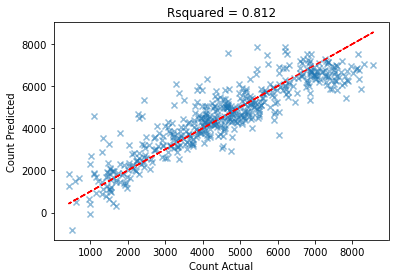

In [364]:
#Final model spread : Ypredicted v/s Yactual with trend line
#Visualizing the spread of model prediction vs actual data and trend line
#Trend line - If model would have predicted all y correctly all points would lie on trend line
X_train_final=X_train[feature_req]
X_train_final_sm=sm.add_constant(X_train_final)
y_pred_train_final=lr.predict(X_train_final_sm)
plt.scatter(y_train, y_pred_train_final,marker='x',alpha=0.5)
plt.plot(y_train, y_train,color="r",linestyle="--")
plt.ylabel("Count Predicted")
plt.xlabel("Count Actual")
plt.title(f"Rsquared = 0.812")
plt.show()

Inference : The actual vs predicted target variable spread is linearly distributed

In [369]:
#Training Metrics
train_rsquared=lr.rsquared
from statsmodels.tools.eval_measures import rmse,meanabs
train_rmse = rmse(y_train, y_pred_train_final)
train_mae = meanabs(y_train, y_pred_train_final)
print(f"The training R-squared is {round(train_rsquared,3)}")
print(f"The training Mean Squared Error is {round(train_rmse,3)}")
print(f"The training Mean Absolute Error is {round(train_mae,3)}")

The training R-squared is 0.812
The training Mean Squared Error is 814.452
The training Mean Absolute Error is 603.529


### Variation of Model Metrics during training and understanding the effect of features on model metrics

In [370]:
def linear_regression_metrics(X_tr,y_tr,features):
    #1. Train the model
    X_train_sm = sm.add_constant(X_tr[features])
    lr = sm.OLS(y_tr, X_train_sm).fit()
    return lr.rsquared,lr.rsquared_adj,lr.mse_model,lr.aic,lr.bic

feature_list=[]
r2_list=[0]
r2adj_list=[0]
mse_list=[0]
aic_list=[0]
bic_list=[0]
for feature in feature_req:
    feature_list.append(feature)
    r2,r2adj,mse,aic,bic=linear_regression_metrics(X_train,y_train,feature_list)
    r2_list.append(r2)
    r2adj_list.append(r2adj)
    mse_list.append(mse)
    aic_list.append(aic)
    bic_list.append(bic)

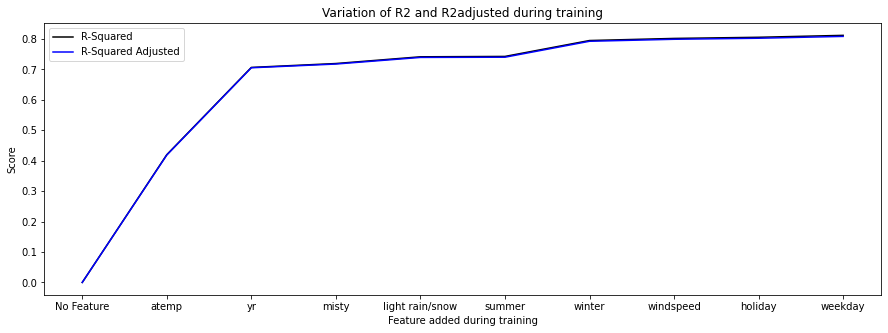

In [371]:
#Training variation of Rsquare
plot_feature_list=["No Feature"]
plot_feature_list.extend(feature_list)
plt.figure(figsize=(15,5))
plt.plot(plot_feature_list,r2_list,color="k",label='R-Squared')
plt.plot(plot_feature_list,r2adj_list,color="b",label='R-Squared Adjusted')
plt.xlabel("Feature added during training")
plt.ylabel("Score")
plt.title("Variation of R2 and R2adjusted during training")
plt.legend()
plt.show()

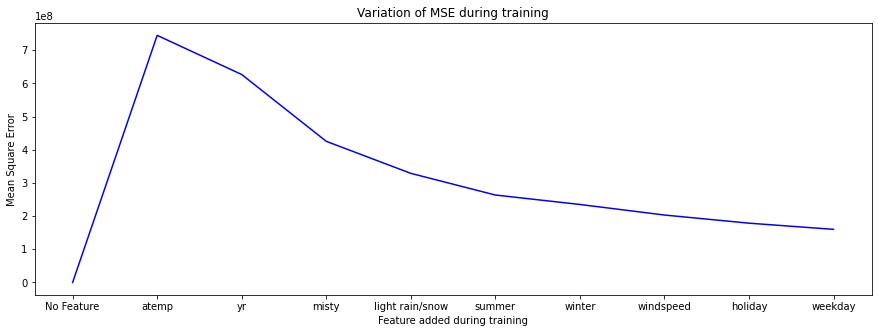

In [372]:
#Training Variation of MSE
plt.figure(figsize=(15,5))
plt.plot(plot_feature_list,mse_list,color="b")
plt.xlabel("Feature added during training")
plt.ylabel("Mean Square Error")
plt.title("Variation of MSE during training")
plt.show()

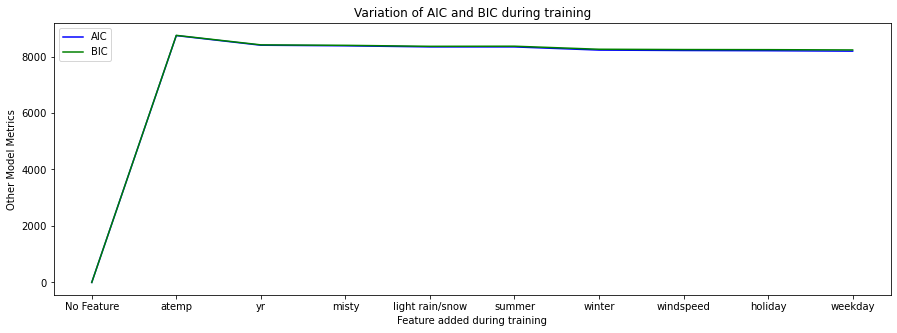

In [373]:
#Training Variation of MSE
plt.figure(figsize=(15,5))
plt.plot(plot_feature_list,aic_list,color="b",label="AIC")
plt.plot(plot_feature_list,bic_list,color="g",label="BIC")
plt.xlabel("Feature added during training")
plt.ylabel("Other Model Metrics")
plt.title("Variation of AIC and BIC during training")
plt.legend()
plt.show()

### 5. Residual Analysis

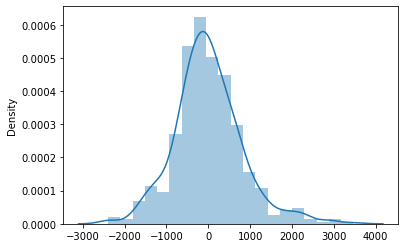

In [374]:
#Residual Distribution
residuals=y_pred_train_final-y_train
sns.distplot(residuals,bins=20)
plt.show()

Normality of Residuals -The errors are randomly distributed

### 6. Evaluation on Test Data

<a id='another_cell'></a>

In [375]:
#Predicting on test
X_test_sm=sm.add_constant(X_test[feature_req])
y_pred_test=lr.predict(X_test_sm)

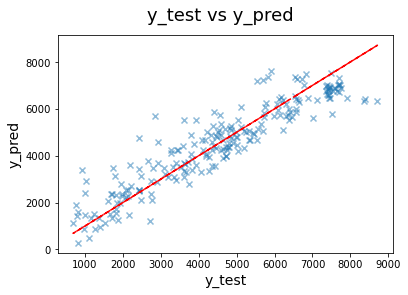

In [376]:
#Understand the spread in test data predicted
# Plotting y_test and y_test_pred to understand the spread

fig = plt.figure()
plt.scatter(y_test, y_pred_test,marker='x',alpha=0.5)
plt.plot(y_test, y_test,color="r",linestyle="--")
fig.suptitle('y_test vs y_pred', fontsize = 18)
plt.xlabel('y_test', fontsize = 14)
plt.ylabel('y_pred', fontsize = 14)    
plt.show()

In [377]:
#Test Metrics
from sklearn.metrics import r2_score
test_rsquared=r2_score(y_test,y_pred_test)
test_rmse = rmse(y_test, y_pred_test)
test_mae = meanabs(y_test, y_pred_test)
print(f"The test R-squared is {round(test_rsquared,3)}")
print(f"The test Mean Squared Error is {round(test_rmse,3)}")
print(f"The test Mean Absolute Error is {round(test_mae,3)}")

The test R-squared is 0.848
The test Mean Squared Error is 792.322
The test Mean Absolute Error is 610.748


### The test Rsquare value is `0.848` where as the train Rsquare value is `0.812`<br>
This can mean that the model is generalizing well on new data

            Actual    Predicted    Residuals
count   216.000000   216.000000   216.000000
mean   4517.666667  4516.478826    -1.187840
std    2038.166858  1795.063125   794.161222
min     683.000000   275.553134 -2395.475415
25%    2882.000000  3310.576993  -550.305613
50%    4562.500000  4660.496903  -103.898248
75%    6185.250000  5978.833422   450.771748
max    8714.000000  7628.001049  2847.995434


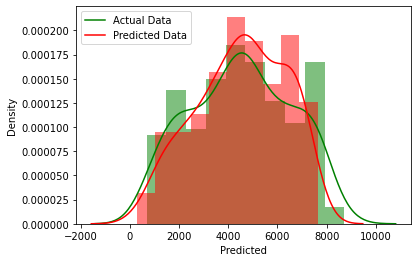

In [465]:
#Distribution of Actual & Predicted Test Data
res_df=pd.DataFrame()
res_df["Actual"]=y_test
res_df["Predicted"]=y_pred_test
res_df["Residuals"]=res_df["Predicted"]-res_df["Actual"]
print(res_df.describe())
sns.distplot(res_df["Actual"],bins=10,color="Green",hist_kws=dict(alpha=0.5))
sns.distplot(res_df["Predicted"],bins=10,color="Red",hist_kws=dict(alpha=0.5))
plt.legend(labels=["Actual Data","Predicted Data"])
plt.title("")
plt.show()

#### Inference : We can infer on the test data, when we plot the distribution of target variable and predicted target variable on test data -
The model is not able to predict for target variable above 6000, however it is able to approximately match the distribution for target variables from 0 to 6000

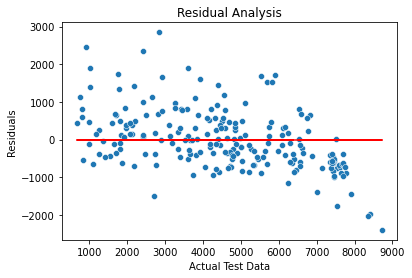

In [474]:
#Residual Analysis
sns.scatterplot(data=res_df,x="Actual",y="Residuals")
plt.xlabel("Actual Test Data")
plt.title("Residual Analysis")
plt.plot(res_df["Actual"],[0]*216,color="red")
plt.show()

#### *Inference* : 
We can infer that for the `target variable below 2000, the model is overpredicting and it has high variance`, the residuals are positive, <br>
and when the `target variable is above 7000, the model is underpredicting` and the residuals are negative

### 7. Equation of Best Fit Line

In [378]:
#The coefficients of the best fit model
lr.params.round(1)

const               835.9
atemp              5015.1
yr                 2007.0
misty              -595.4
light rain/snow   -2090.3
summer              525.9
winter             1027.1
windspeed          -812.6
holiday            -599.2
weekday              75.4
dtype: float64


Equation of the best fitted line is:

$ cnt = 835.9 + 5015.1  \times  atemp + 2007.0  \times  yr + 1027.1 \times winter + 525.9 \times summer  + 75.4 \times weekday - 2090.3 \times light rain/snow - 812.6 \times windspeed - 599.2 \times holiday - 595.4 \times misty $

Conclusion : `Actual Temperature`,`Year` & `Weather condition :lightrain/snow` affect the demand of the bikes the most for the bike sharing platform<br>. The model is facing some difficulty predicting extreme low and high values of the target variable

<br>
  **Positive Indicators on order of importance :**
1. atemp<br>
2. yr<br>
3. winter<br>
4. summer<br>
5. weekday<br>

  **Negative Indicators on order of importance :**<br>
1. light rain/snow
2. windspeed
3. holiday
4. misty

